In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Data/')
from analysis_util import *

In [4]:
with open('/content/drive/My Drive/Data/padded/X_padded_80.pkl', 'rb') as fp:
  X = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y_classes = pickle.load(fp)

In [5]:
y = np.array(pd.get_dummies(y_classes))

In [6]:
# classes = get_classes(y_train)
# cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [7]:
val_test_size = int(len(y)*.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_test_size, random_state=42)

In [8]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

478426
102519
102519


In [9]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

478426
102519
102519


In [10]:
dropout_rate=.3

input = keras.layers.Input(shape=(80, 80, 1))

# A convolution block
x = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(input)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)


# Uncomment the below line if you're using dense layers
# x = tf.keras.layers.GlobalMaxPooling2D()(x)

# Fully connected layer 1
# x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(units=64)(x)
# x = tf.keras.layers.Activation('relu')(x)

# Fully connected layer 1
x = keras.layers.Conv2D(1028, kernel_size=1, strides=1)(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

# Fully connected layer 2
# x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(units=len_classes)(x)
# predictions = tf.keras.layers.Activation('softmax')(x)

# Fully connected layer 2
x = keras.layers.Conv2D(514, kernel_size=1, strides=1)(x)
# x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalMaxPooling2D()(x)
predictions = keras.layers.Activation('softmax')(x)

model = keras.Model(inputs=input, outputs=predictions)
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 80, 80, 64)       

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['acc'])

In [12]:
# X_trial=np.asarray(X_train[0]).reshape(149,118,1)
# X_trial.shape

In [13]:
# xdim, ydim = X_train[0].size
# model.train_on_batch([X_trial], y_train[0])

In [14]:
history = model.fit(
    np.asarray([np.asarray(x) for x in X_train]).reshape(-1,80,80,1), 
    np.array(y_train), 
    epochs=1, 
    batch_size=80,
    # class_weight=cw,
    validation_data=(np.asarray([np.asarray(x) for x in X_val]).reshape(-1,80,80,1), y_val))

5981/5981 [==============================] - 3454s 578ms/step - loss: 4.2598 - acc: 0.1747 - val_loss: 4.6341 - val_acc: 0.1375


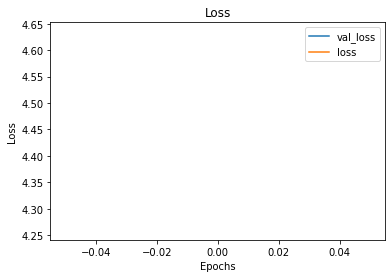

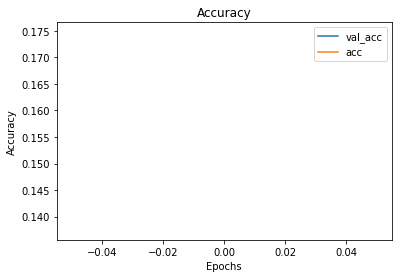

In [15]:
visualize_training_results(history)

In [17]:
yhat_test = get_classes(model.predict(np.asarray([np.asarray(x) for x in X_test]).reshape(-1,80,80,1)))
dummy_to_unicode = dict(enumerate(pd.get_dummies(y_classes).columns))

In [18]:
print(classification_report(get_classes(y_test), yhat_test))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.64      0.25      0.36       186
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00       132
           4       0.00      0.00      0.00       358
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00       890
           8       0.00      0.00      0.00      1832
           9       0.05      0.03      0.04      1004
          10       0.00      0.00      0.00        96
          11       0.04      0.37      0.07       903
          12       0.16      0.04      0.06      2187
          13       0.00      0.00      0.00       947
          14       0.05      0.23      0.08      1147
          15       0.00      0.00      0.00        92
          16       0.24      0.05      0.08      1361
          17       0.00    

In [19]:
misclassifications = misclass_report(get_classes(y_test), yhat_test, dummy_to_unicode)

In [20]:
index=45
print(chr(int(dummy_to_unicode[index][2:], 16)))
# print(513)
misclassifications[index]

ね


['う',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'お',
 'か',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'き',
 'く',
 'し',
 'し',
 'し',
 'し',
 'し',
 'し',
 'す',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'な',
 'に',
 'ふ',
 'ふ',
 'ふ',
 'へ',
 'へ',
 'へ',
 'へ',
 'へ',
 'へ',
 'め',
 'も',
 'も',
 'も',
 'も',
 'ら',
 'ら',
 'ら',
 'ら',
 'ら',
 'り',
 'り'

In [ ]:
model.save('/content/drive/My Drive/Models/fcn')